In [1]:
import pandas as pd
from pycaret.regression import setup, compare_models, tune_model, finalize_model, predict_model, plot_model

In [2]:
# Cargamos los datasets
dfpatentes = pd.read_csv('../Analisis/datasetPatentes.csv')
dfsnii = pd.read_csv('../Analisis/datasetSNII.csv')
dfwos = pd.read_csv('../Analisis/datasetWoS.csv')
dfkeys = pd.read_csv('../Analisis/Nombres_PxS.csv')

# Normalizamos nombres de columnas
for df in (dfpatentes, dfsnii, dfwos,dfkeys):
    df.columns = (
        df.columns
        .str.lower()
        .str.strip()
        .str.replace(' ', '_')
        .str.replace('-', '_')
    )

In [3]:
# Eliminamos las columnas del dfkeys 'nombre_inventor', 'nombre_del_investigador'
dfkeys = dfkeys.drop(columns=['nombre_inventor', 'nombre_del_investigador'])
# Eliminamos los NA de la columna 'inventor_id'
dfkeys = dfkeys.dropna(subset=['inventor_id'])
# Convertimos la columna 'inventor_id' a int
dfkeys['cvu'] = dfkeys['cvu'].astype(int)

In [4]:
# Contamos la cantidad nombres que hay en la columna 'authors' que estan separadas por ';'
dfwos['numCoautores'] = dfwos['authors'].str.split(';').str.len()

In [5]:
# Quitar espacios en los extremos
dfsnii['nivel'] = (
    dfsnii['nivel']
    .astype(str)              
    .str.strip()              
    .replace({
        r'.*Nivel I$': 1,
        r'.*Nivel II$': 2,
        r'.*Nivel III$': 3,
        r'.*Candidato.*': 'C',
        r'^Emérito$': 'E'
    }, regex=True)
    .astype(str)
)

# Normalizar formatos de fecha a 'YYYY-MM-DD' sin eliminar vals no estándar
def normalize_date(val):
    try:
        return pd.to_datetime(val, dayfirst=True).strftime('%Y-%m-%d')
    except Exception:
        return val

for col in ['fecha_de_inicio_de_vigencia', 'fecha_de_fin_de_vigencia']:
    dfsnii[col] = dfsnii[col].apply(normalize_date)

# Definir función para extraer años de forma segura
def safe_year(val):
    try:
        return pd.to_datetime(val, dayfirst=True, errors='coerce').year
    except:
        return None

# Extraer años de inicio y fin
dfsnii['anio_inicio'] = dfsnii['año']  # Se asume que 'año' ya está en formato correcto
dfsnii['anio_fin'] = dfsnii['fecha_de_fin_de_vigencia'].apply(safe_year)

# Ordenar por cvu y año de fin (descendente)
dfsnii = dfsnii.sort_values(['cvu', 'anio_fin'], ascending=[True, False])

# Agrupar por cvu y nivel, y calcular la actividad
def calcular_actividad(grupo):
    grupo = grupo.sort_values('anio_inicio')  # Ordenar por año de inicio
    actividad = f"{grupo['anio_inicio'].iloc[0]}-{grupo['anio_fin'].iloc[-1]}"
    return pd.Series({
        'Actividad': actividad,
        'anio_inicio': grupo['anio_inicio'].iloc[0],
        'anio_fin': grupo['anio_fin'].iloc[-1]
    })

dfsnii_actividad = (
    dfsnii.groupby(['cvu', 'nivel'])
    .apply(calcular_actividad)
    .reset_index()
)

# Quedarse con el año más reciente de cada nivel
dfsnii_recent = dfsnii_actividad.sort_values(['cvu', 'anio_fin'], ascending=[True, False])
dfsnii_recent = dfsnii_recent.drop_duplicates(subset=['cvu', 'nivel'], keep='first')

# Eliminamos la columna anio_inicio, anio_fin
dfsnii_recent = dfsnii_recent.drop(columns=['anio_inicio', 'anio_fin'])

# Limpiamos los datos
dfsnii = dfsnii.sort_values(['cvu', 'anio_inicio'], ascending=[True, False])
dfsnii = dfsnii.drop_duplicates(subset=['cvu', 'nivel'], keep='first')

# Eliminamos la columna anio_inicio, anio_fin y cruzamos con el dataset de actividad
dfsnii = dfsnii.drop(columns=['anio_inicio', 'anio_fin'])

# Convertimos int la columna cvu sin decimales del dfsnii_recent
dfsnii_recent['cvu'] = dfsnii_recent['cvu'].astype(int)
dfsnii['cvu'] = dfsnii['cvu'].astype(int)
# Quitamos el decimal a la columna 'Actividad' del dfsnii_recent
dfsnii_recent['Actividad'] = dfsnii_recent['Actividad'].str.replace('.0', '', regex=False)

# Cruzamos los dataserts para solo recuperar el Actividad dfsnii_recent
dfsnii = dfsnii.merge(dfsnii_recent, on=['cvu', 'nivel'], how='left', suffixes=('', '_y'))

# Reducir SNII a un registro por CVU (por ejemplo, el más reciente)
dfsnii = (
    dfsnii
    .sort_values("fecha_de_fin_de_vigencia")
    .drop_duplicates(subset="cvu", keep="last")
)

del dfsnii_actividad, dfsnii_recent, df

In [6]:
# Merge de las tablas
dfFinal = (
    dfkeys
      .merge(dfsnii, on="cvu", how="inner", suffixes=('', '_snii'))
      .merge(dfpatentes, on="inventor_id", how="inner", suffixes=('', '_patentes'))
      .merge(dfwos, left_on="nombre_snii", right_on="investigador", how="inner", suffixes=('', '_wos'))
)

,Description,Value
0,Session id,42
1,Target,total_publicaciones
2,Target type,Regression
3,Original data shape,"(4040, 122)"
4,Transformed data shape,"(4040, 122)"
5,Transformed train set shape,"(2828, 122)"
6,Transformed test set shape,"(1212, 122)"
7,Numeric features,6
8,Categorical features,115
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,2.3817,23.4270,4.7191,0.9922,0.3052,0.1931,0.6090
lasso,Lasso Regression,2.3755,24.9786,4.8465,0.9920,0.3039,0.1715,0.6600
ridge,Ridge Regression,2.3705,23.7015,4.7555,0.9920,0.3217,0.2149,1.5700
llar,Lasso Least Angle Regression,2.3756,24.9785,4.8465,0.9920,0.3039,0.1715,0.6840
br,Bayesian Ridge,2.3715,23.7727,4.7630,0.9920,0.3217,0.2158,0.6050
huber,Huber Regressor,2.0760,25.2764,4.8856,0.9919,0.2527,0.1539,1.1840
et,Extra Trees Regressor,2.3665,34.6487,5.5133,0.9897,0.2627,0.1715,2.1280
gbr,Gradient Boosting Regressor,2.3067,36.2981,5.7093,0.9896,0.2461,0.1640,0.8220
rf,Random Forest Regressor,2.3945,40.2850,5.9993,0.9888,0.2483,0.1664,1.6470
par,Passive Aggressive Regressor,4.0817,44.4541,6.5585,0.9852,0.6078,0.5044,0.6170


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.7925,33.3531,5.7752,0.9943,0.2974,0.1887
1,2.5462,20.4210,4.5190,0.9868,0.3114,0.1951
2,2.3365,18.3581,4.2846,0.9844,0.3215,0.2332
3,2.2387,15.7619,3.9701,0.9966,0.2903,0.1863
4,2.8022,56.5696,7.5213,0.9888,0.2766,0.1911
5,2.2115,19.2780,4.3907,0.9944,0.3124,0.1629
6,2.1825,15.6035,3.9501,0.9928,0.3260,0.1898
7,2.1885,13.7187,3.7039,0.9971,0.2967,0.1876
8,2.3598,18.0673,4.2506,0.9958,0.3003,0.1815


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.2943,25.8691,5.0862,0.9918,0.2995,0.2030


Columnas disponibles en preds: ['patents', 'años_patente', 'prop_coinv_mujeres', 'h_index', 'citas_pub', 'vigencia_años', 'nivel_2', 'nivel_3', 'nivel_C', 'nivel_E', 'área_del_conocimiento_II.- BIOLOGÍA Y QUÍMICA', 'área_del_conocimiento_III.- MEDICINA Y CIENCIAS DE LA SALUD', 'área_del_conocimiento_IV.- HUMANIDADES Y CIENCIAS DE LA CONDUCTA', 'área_del_conocimiento_V.- CIENCIAS SOCIALES', 'área_del_conocimiento_V.- HUMANIDADES.', 'área_del_conocimiento_VI.- BIOTECNOLOGÍA Y CIENCIAS AGROPECUARIAS', 'área_del_conocimiento_VI.- CIENCIAS SOCIALES', 'área_del_conocimiento_VII.- CIENCIAS DE AGRICULTURA, AGROPECUARIAS, FORESTALES Y DE ECOSISTEMAS', 'área_del_conocimiento_VII.- INGENIERÍAS', 'área_del_conocimiento_VII.- INGENIERÍAS ', 'área_del_conocimiento_VIII.- INGENIERÍAS Y DESARROLLO TECNOLÓGICO', 'disciplina_AGRONOMIA', 'disciplina_BIOLOGIA CELULAR', 'disciplina_BIOLOGIA MOLECULAR', 'disciplina_BIOQUIMICA', 'disciplina_CALCULO DE PROBABILIDADES', 'disciplina_CAMBIO Y DESARROLLO SOCIAL',

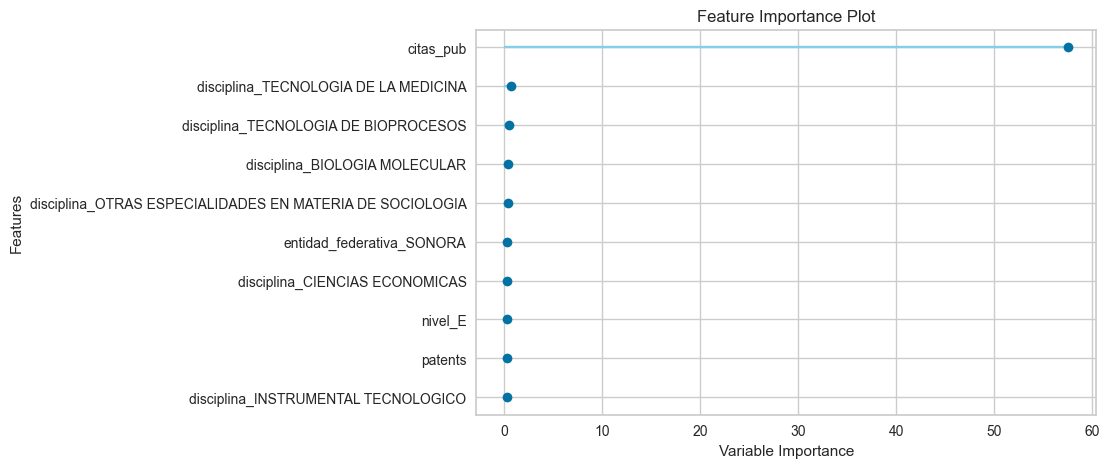

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.3401,24.2606,4.9255,0.9928,0.2979,0.1838


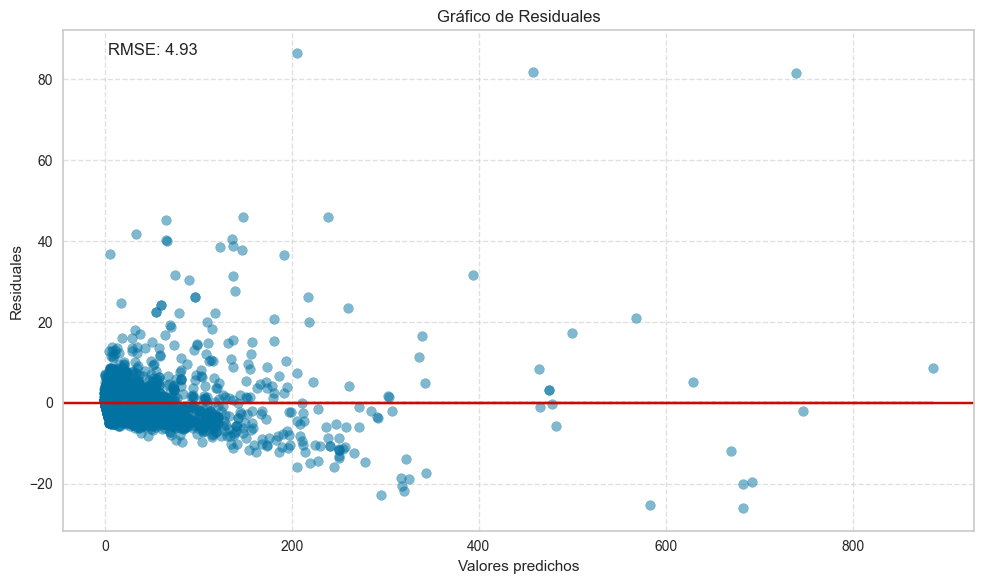

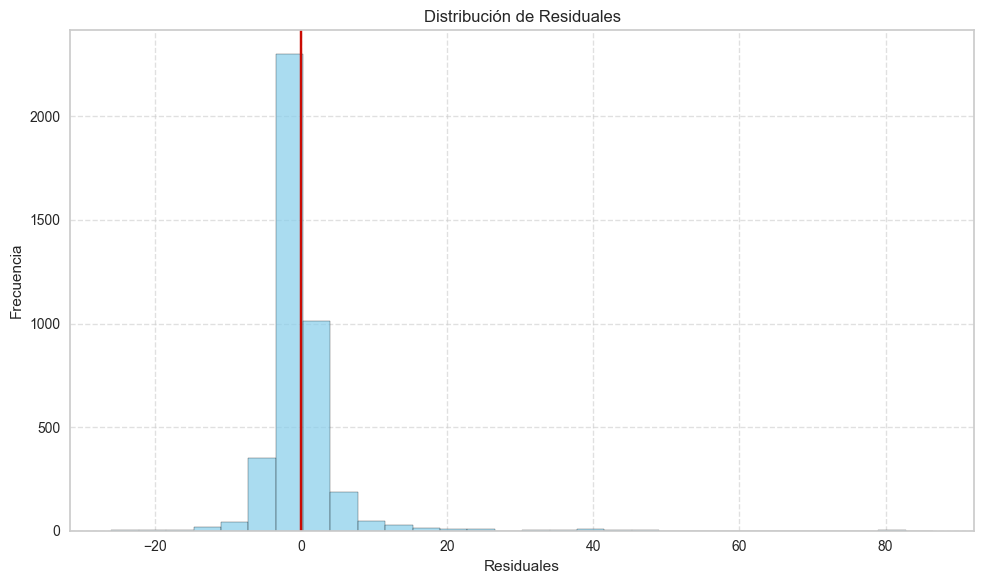

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

dfEntrenamiento = dfFinal.copy()

# Llenamos los valores de la columna 'co_inventoras_mujeres' con 0
dfEntrenamiento['co_inventoras_mujeres'] = dfEntrenamiento['co_inventoras_mujeres'].fillna(0)
dfEntrenamiento['número_de_coinventores'] = dfEntrenamiento['número_de_coinventores'].fillna(0)

# Patentes
# Asegurarse de que las columnas sean numéricas
dfEntrenamiento['co_inventoras_mujeres'] = pd.to_numeric(dfEntrenamiento['co_inventoras_mujeres'], errors='coerce')
dfEntrenamiento['número_de_coinventores'] = pd.to_numeric(dfEntrenamiento['número_de_coinventores'], errors='coerce')

dfEntrenamiento['años_patente'] = dfEntrenamiento['última_patente'].astype(int) - dfEntrenamiento['año_de_inicio'].astype(int)

# Evitar divisiones por cero
dfEntrenamiento['prop_coinv_mujeres'] = dfEntrenamiento['co_inventoras_mujeres'] / (dfEntrenamiento['número_de_coinventores'] + 1e-9)

# Publicaciones WoS
cols_anuales = [str(y) for y in range(2000, 2025)]
dfEntrenamiento['total_publicaciones'] = dfEntrenamiento[cols_anuales].sum(axis=1)
dfEntrenamiento['h_index'] = dfEntrenamiento['h']
dfEntrenamiento['citas_pub'] = dfEntrenamiento['total_de_citas']

# SNII
dfEntrenamiento['vigencia_años'] = (
    pd.to_datetime(dfEntrenamiento['fecha_de_fin_de_vigencia']) -
    pd.to_datetime(dfEntrenamiento['fecha_de_inicio_de_vigencia'])
).dt.days / 365

# One-hot encoding de variables categóricas
dfEntrenamiento = pd.get_dummies(
dfEntrenamiento,
columns=['nivel', 'área_del_conocimiento', 'disciplina', 'entidad_federativa'],
drop_first=True
)

# Verificar y manejar valores faltantes en columnas numéricas y categóricas
numeric_cols = ['patents', 'años_patente', 'prop_coinv_mujeres', 'h_index', 'citas_pub', 'vigencia_años']
categorical_cols = [c for c in dfEntrenamiento.columns if c.startswith(('nivel_', 'área_', 'disciplina_', 'entidad_'))]

# Validar y limpiar columnas numéricas
for col in numeric_cols:
    dfEntrenamiento[col] = pd.to_numeric(dfEntrenamiento[col], errors='coerce')
    dfEntrenamiento[col] = dfEntrenamiento[col].fillna(0)

# Validar columnas categóricas
for col in categorical_cols:
    if not pd.api.types.is_categorical_dtype(dfEntrenamiento[col]):
        dfEntrenamiento[col] = dfEntrenamiento[col].astype('category')

# Verificar que no existan valores faltantes en las columnas categóricas
dfEntrenamiento = dfEntrenamiento.dropna(subset=categorical_cols)

# Filtrar solo columnas relevantes para el modelo
columnas_modelo = numeric_cols + categorical_cols + ['total_publicaciones']
dfEntrenamiento = dfEntrenamiento[columnas_modelo].copy()

# Definir experimento en PyCaret
exp = setup(
    data=dfEntrenamiento,
    target='total_publicaciones', # Variable objetivo: publicaciones
    numeric_features=numeric_cols,
    categorical_features=categorical_cols,
    normalize=True,
    imputation_type=None, # Desactivar imputación automática
    session_id=42
)

# Comparar y tunear modelos
best = compare_models() # Elegir el mejor modelo
tuned = tune_model(best) # Afinar el modelo
final = finalize_model(tuned) # Entrenar en todo el conjunto de datos

# Predicción sobre hold-out (por ejemplo, últimos 20%)
# Asegurarnos que el holdout tiene las mismas columnas que el dataset de entrenamiento
df_holdout = dfEntrenamiento.sample(frac=0.2, random_state=42)
preds = predict_model(final, data=df_holdout)

# Mostrar las columnas disponibles en preds
def print_pred_cols(df):
    print("Columnas disponibles en preds:", list(df.columns))
    cols = [c for c in ['total_publicaciones', 'Label', 'Score'] if c in df.columns]
    print(df[cols].head())

print_pred_cols(preds)

# Resultados (plots sobre el conjunto completo)
# Solo generamos el gráfico de importancia de variables que funciona correctamente
plot_model(final, plot='feature') # Importancia de variables

# Predecir sobre el conjunto completo de datos
preds_full = predict_model(final, data=dfEntrenamiento)

# Calcular residuales
# Verificar si la columna 'Label' existe, de lo contrario usar 'prediction_label'
predicted_column = 'Label' if 'Label' in preds_full.columns else 'prediction_label'
residuals = dfEntrenamiento['total_publicaciones'] - preds_full[predicted_column]

# Crear gráfico de residuales vs valores predichos
plt.figure(figsize=(10, 6))
plt.scatter(preds_full[predicted_column], residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Valores predichos')
plt.ylabel('Residuales')
plt.title('Gráfico de Residuales')
z = np.polyfit(preds_full[predicted_column], residuals, 1)
p = np.poly1d(z)
plt.plot(preds_full[predicted_column], p(preds_full[predicted_column]), 'r--', alpha=0.5)

# Mostrar RMSE
rmse = mean_squared_error(dfEntrenamiento['total_publicaciones'], preds_full[predicted_column], squared=False)
plt.annotate(f'RMSE: {rmse:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Histograma de residuales
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='r', linestyle='-')
plt.xlabel('Residuales')
plt.ylabel('Frecuencia')
plt.title('Distribución de Residuales')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

---

In [21]:
for col in [c for c in dfEntrenamiento.columns if c.startswith('área_del_conocimiento_')]:
    subset = dfEntrenamiento[dfEntrenamiento[col] == True]
    print(f"Área: {col}, Tamaño del subconjunto: {len(subset)}")
    print(f"Desviación estándar de total_publicaciones: {subset['total_publicaciones'].std()}")
    print(f"Desviación estándar de patents: {subset['patents'].std()}")

Área: área_del_conocimiento_II.- BIOLOGÍA Y QUÍMICA, Tamaño del subconjunto: 845
Desviación estándar de total_publicaciones: 63.63687467667796
Desviación estándar de patents: 4.94749260265911
Área: área_del_conocimiento_III.- MEDICINA Y CIENCIAS DE LA SALUD, Tamaño del subconjunto: 240
Desviación estándar de total_publicaciones: 37.486923801066226
Desviación estándar de patents: 5.115116588377216
Área: área_del_conocimiento_IV.- HUMANIDADES Y CIENCIAS DE LA CONDUCTA, Tamaño del subconjunto: 70
Desviación estándar de total_publicaciones: 14.014780721614885
Desviación estándar de patents: 3.745224702809454
Área: área_del_conocimiento_V.- CIENCIAS SOCIALES, Tamaño del subconjunto: 5
Desviación estándar de total_publicaciones: 7.8230428862431785
Desviación estándar de patents: 2.5099800796022267
Área: área_del_conocimiento_V.- HUMANIDADES., Tamaño del subconjunto: 16
Desviación estándar de total_publicaciones: 20.269846241811177
Desviación estándar de patents: 1.526160760426852
Área: área_

Áreas con mayor correlación entre publicaciones y patentes:
área_del_conocimiento_III.- MEDICINA Y CIENCIAS DE LA SALUD: 0.35784371465163406
área_del_conocimiento_VI.- CIENCIAS SOCIALES: 0.23292672832469036
área_del_conocimiento_VIII.- INGENIERÍAS Y DESARROLLO TECNOLÓGICO: 0.0910046350063731
área_del_conocimiento_II.- BIOLOGÍA Y QUÍMICA: -0.006226310787740035
área_del_conocimiento_VII.- INGENIERÍAS: -0.06992425996519212


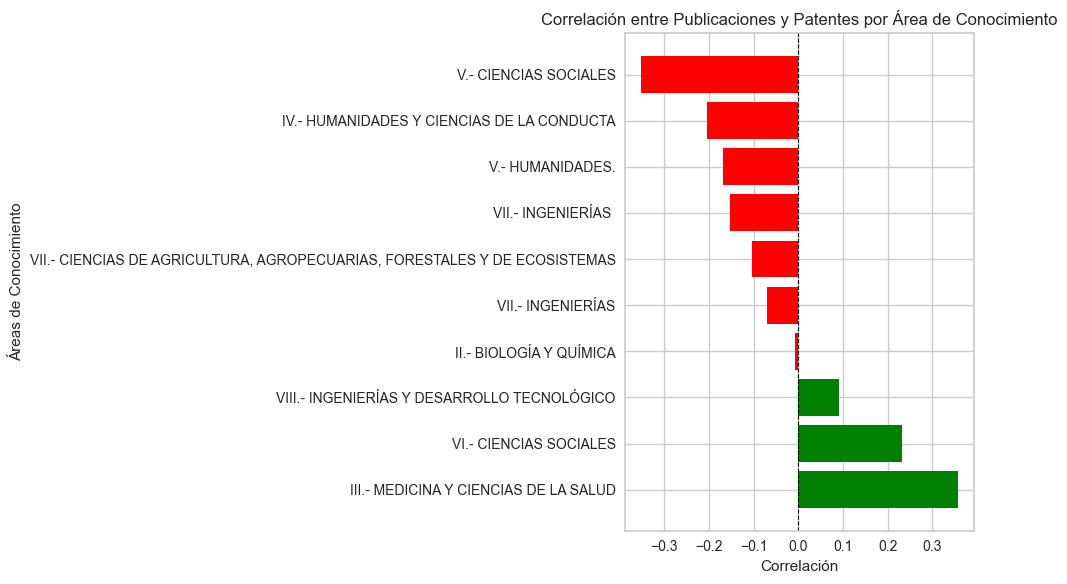

In [26]:
import matplotlib.pyplot as plt

# Calcular correlación por área de conocimiento
correlaciones = {}
for col in [c for c in dfEntrenamiento.columns if c.startswith('área_del_conocimiento_')]:
    subset = dfEntrenamiento[dfEntrenamiento[col] == True]
    
    # Validar que el subconjunto tenga suficientes datos y variación
    if len(subset) > 1 and subset['total_publicaciones'].std() > 0 and subset['patents'].std() > 0:
        correlaciones[col] = subset['total_publicaciones'].corr(subset['patents'])
    else:
        correlaciones[col] = None  # No calcular si no hay suficientes datos o variación

# Ordenar las áreas por correlación
correlaciones_ordenadas = sorted(correlaciones.items(), key=lambda x: x[1] if x[1] is not None else -float('inf'), reverse=True)

print("Áreas con mayor correlación entre publicaciones y patentes:")
for area, corr in correlaciones_ordenadas[:5]:
    print(f"{area}: {corr}")

# Filtrar áreas con valores calculables
areas = [area.replace('área_del_conocimiento_', '').replace('_', ' ') for area, corr in correlaciones_ordenadas if corr is not None]
valores = [corr for area, corr in correlaciones_ordenadas if corr is not None]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(areas, valores, color=['green' if c > 0 else 'red' for c in valores])

# Añadir etiquetas y título
plt.xlabel("Correlación")
plt.ylabel("Áreas de Conocimiento")
plt.title("Correlación entre Publicaciones y Patentes por Área de Conocimiento")
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)  # Línea vertical en 0 para separar positivas y negativas

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [27]:
from statsmodels.tsa.stattools import grangercausalitytests

# Preparar datos para análisis de causalidad
df_causalidad = dfEntrenamiento[['total_publicaciones', 'patents']].dropna()

# Evaluar causalidad (publicaciones -> patentes y viceversa)
print("Causalidad: Publicaciones -> Patentes")
grangercausalitytests(df_causalidad[['total_publicaciones', 'patents']], maxlag=2)

print("Causalidad: Patentes -> Publicaciones")
grangercausalitytests(df_causalidad[['patents', 'total_publicaciones']], maxlag=2)

Causalidad: Publicaciones -> Patentes

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7555  , p=0.0970  , df_denom=4036, df_num=1
ssr based chi2 test:   chi2=2.7575  , p=0.0968  , df=1
likelihood ratio test: chi2=2.7566  , p=0.0969  , df=1
parameter F test:         F=2.7555  , p=0.0970  , df_denom=4036, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9361  , p=0.3923  , df_denom=4033, df_num=2
ssr based chi2 test:   chi2=1.8744  , p=0.3917  , df=2
likelihood ratio test: chi2=1.8740  , p=0.3918  , df=2
parameter F test:         F=0.9361  , p=0.3923  , df_denom=4033, df_num=2
Causalidad: Patentes -> Publicaciones

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0793  , p=0.7783  , df_denom=4036, df_num=1
ssr based chi2 test:   chi2=0.0793  , p=0.7782  , df=1
likelihood ratio test: chi2=0.0793  , p=0.7782  , df=1
parameter F test:         F=0.0793  , p=0.7783  , df_denom=4036, df_num=1

Granger Cau

{1: ({'ssr_ftest': (0.07928822605046615, 0.778278747422824, 4036.0, 1),
   'ssr_chi2test': (0.07934716179827374, 0.7781840736559273, 1),
   'lrtest': (0.07934638241022185, 0.7781851345432138, 1),
   'params_ftest': (0.07928822604991421, 0.7782787474234343, 4036.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.009277115269905, 0.3645744036239785, 4033.0, 2),
   'ssr_chi2test': (2.0210567773170722, 0.36402658122852166, 2),
   'lrtest': (2.0205511671028944, 0.36411862064089895, 2),
   'params_ftest': (1.0092771152691635, 0.36457440362424265, 4033.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

### **1. Estructura de la salida**
Para cada dirección de causalidad (`Publicaciones -> Patentes` y `Patentes -> Publicaciones`), se realizan pruebas con diferentes números de rezagos (`lags`). Los resultados incluyen:

- **`ssr based F test`**: Prueba basada en la suma de residuos al cuadrado (SSR) con un estadístico F.
- **`ssr based chi2 test`**: Prueba basada en SSR con un estadístico chi-cuadrado.
- **`likelihood ratio test`**: Prueba basada en la razón de verosimilitud.
- **`parameter F test`**: Prueba basada en los parámetros del modelo con un estadístico F.
- **`p`**: Valor p asociado a cada prueba, que indica la significancia estadística.

---

### **2. Interpretación de los resultados**
#### **Causalidad: Publicaciones -> Patentes**
- **Rezago 1 (`number of lags (no zero) 1`)**:
  - `p=0.0970` (F test): El valor p es mayor que el nivel de significancia típico (0.05), lo que indica que no hay evidencia suficiente para rechazar la hipótesis nula. Esto significa que no se puede concluir que las publicaciones causen patentes con un rezago de 1.
  
- **Rezago 2 (`number of lags (no zero) 2`)**:
  - `p=0.3923` (F test): Similar al caso anterior, el valor p es mayor que 0.05, lo que indica que no hay evidencia de causalidad de publicaciones hacia patentes con un rezago de 2.

#### **Causalidad: Patentes -> Publicaciones**
- **Rezago 1 (`number of lags (no zero) 1`)**:
  - `p=0.7783` (F test): El valor p es mucho mayor que 0.05, lo que indica que no hay evidencia de que las patentes causen publicaciones con un rezago de 1.

- **Rezago 2 (`number of lags (no zero) 2`)**:
  - `p=0.3646` (F test): Nuevamente, el valor p es mayor que 0.05, lo que indica que no hay evidencia de causalidad de patentes hacia publicaciones con un rezago de 2.

---

### **3. Conclusión**
- **No hay evidencia de causalidad estadísticamente significativa** en ninguna dirección (`Publicaciones -> Patentes` o `Patentes -> Publicaciones`) para los rezagos evaluados (1 y 2).
- Esto significa que, según el test de Granger, no se puede afirmar que las publicaciones predicen las patentes ni que las patentes predicen las publicaciones en este conjunto de datos.

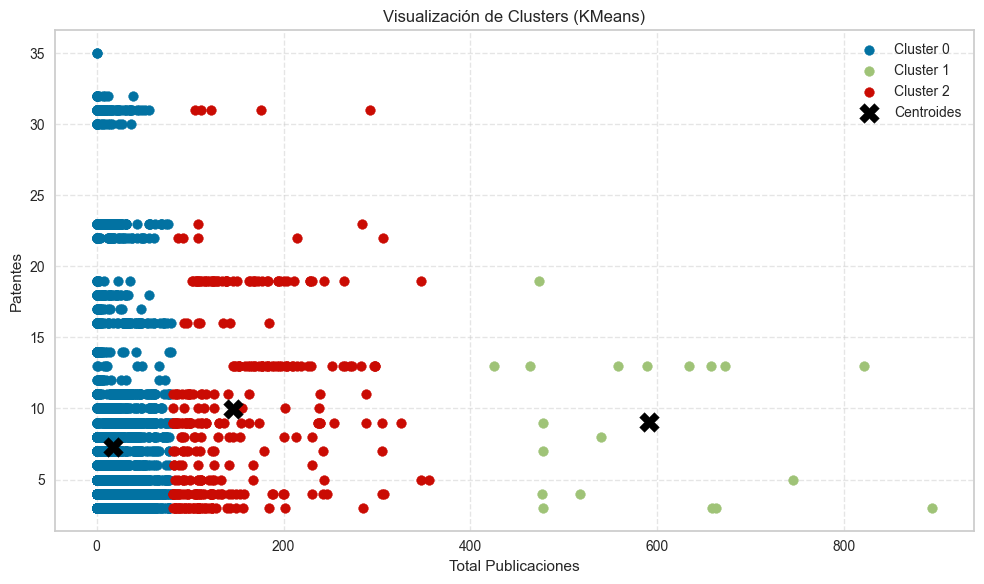

Importancia de características: [0.95246711 0.04753289]


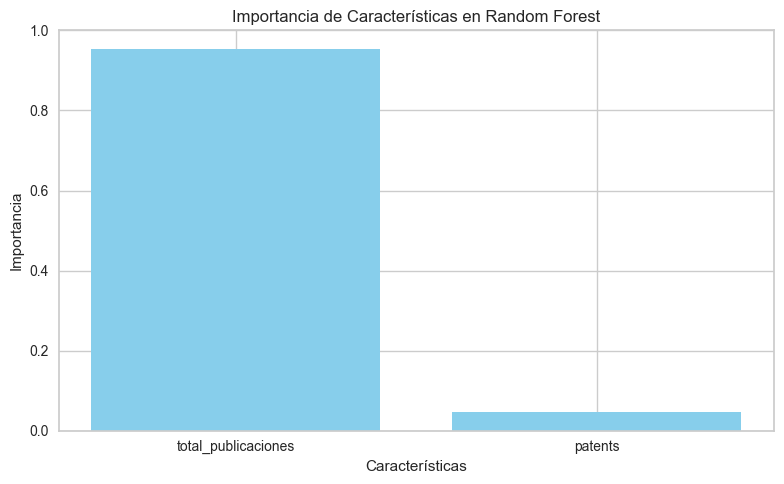

In [34]:
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Clustering
X = dfEntrenamiento[['total_publicaciones', 'patents']].dropna()
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
dfEntrenamiento['cluster'] = kmeans.labels_

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
for cluster in range(kmeans.n_clusters):
    cluster_data = X[dfEntrenamiento['cluster'] == cluster]
    plt.scatter(cluster_data['total_publicaciones'], cluster_data['patents'], label=f'Cluster {cluster}')

# Añadir los centroides al gráfico
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='black', marker='X', label='Centroides')

# Etiquetas y título
plt.xlabel('Total Publicaciones')
plt.ylabel('Patentes')
plt.title('Visualización de Clusters (KMeans)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Clasificación con Random Forest
X = dfEntrenamiento[['total_publicaciones', 'patents']]
y = dfEntrenamiento['cluster']
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Importancia de características
importances = rf.feature_importances_
features = ['total_publicaciones', 'patents']
print("Importancia de características:", importances)

# Crear la gráfica de barras
plt.figure(figsize=(8, 5))
plt.bar(features, importances, color='skyblue')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('Importancia de Características en Random Forest')
plt.tight_layout()
plt.show()

### **1. Gráfica de Clusters (KMeans)**
- **Agrupamiento de datos**:
  - Los datos se agrupan en tres clusters (`Cluster 0`, `Cluster 1`, `Cluster 2`), lo que indica que existen patrones diferenciados en la relación entre `total_publicaciones` y `patents`.
  - Los centroides (marcados con `X` negro) representan los puntos centrales de cada cluster.

- **Distribución de los clusters**:
  - **Cluster 0 (azul)**: Representa la mayoría de los datos con pocas publicaciones (`total_publicaciones` bajas) y un rango bajo a medio de patentes (`patents`).
  - **Cluster 1 (rojo)**: Incluye datos con un rango medio de publicaciones y patentes.
  - **Cluster 2 (verde)**: Representa casos con un número alto de publicaciones y un rango bajo a medio de patentes.

- **Patrón observado**:
  - Existe una relación no lineal entre publicaciones y patentes. Los datos con muchas publicaciones no necesariamente tienen muchas patentes, lo que sugiere que otros factores pueden influir en la generación de patentes.

---

### **2. Gráfica de Importancia de Características (Random Forest)**
- **Importancia de las variables**:
  - La variable `total_publicaciones` tiene una importancia significativamente mayor (~95%) en la clasificación de los clusters en comparación con `patents` (~5%).
  - Esto indica que el número de publicaciones es el factor principal que influye en cómo se agrupan los datos en los clusters.

- **Interpretación**:
  - Aunque las patentes tienen cierta relevancia, su impacto en la segmentación es mucho menor que el de las publicaciones.
  - Esto sugiere que las publicaciones son un indicador más fuerte de los patrones observados en los datos.

---

### **3. Relación entre Patentes y Artículos**
- **Patrones identificados**:
  - Los datos muestran que no existe una relación lineal directa entre el número de publicaciones y el número de patentes.
  - Los clusters indican que hay subgrupos de investigadores o entidades con diferentes comportamientos:
    - Algunos producen muchas publicaciones pero pocas patentes.
    - Otros tienen un equilibrio entre publicaciones y patentes.

- **Diferencias significativas**:
  - Los datos con un número muy alto de publicaciones (Cluster 2) parecen ser casos atípicos, ya que tienen pocas patentes en comparación con su volumen de publicaciones.
  - Los datos con pocas publicaciones (Cluster 0) tienden a tener un rango más amplio de patentes, lo que podría indicar que la calidad o el enfoque de las publicaciones es más relevante que la cantidad.

---

### **Conclusión**
- **Publicaciones como principal factor**:
  - El número de publicaciones es el principal determinante en la segmentación de los datos, pero no siempre se traduce en un mayor número de patentes.
  
- **Relación compleja**:
  - La relación entre publicaciones y patentes no es lineal ni directa. Esto sugiere que otros factores (como el área de investigación, la calidad de las publicaciones o el enfoque en innovación) podrían influir en la generación de patentes.

- **Siguientes pasos**:
  - Analizar otras variables (como áreas de conocimiento, disciplinas o regiones) para entender mejor los factores que impulsan la generación de patentes.
  - Explorar modelos más complejos o no lineales para capturar relaciones más sutiles entre publicaciones y patentes.

In [3]:
import pandas as pd

# Leemos el archivo
df = pd.read_csv('E:\\Documentos\\Programas Uni\\PT\\SNII-Insight\\Analisis\\datasetSNII.csv')

# Creamos un DataFrame para cada columna con sus valores únicos
df_area = pd.DataFrame(df['ÁREA DEL CONOCIMIENTO'].unique(), columns=['ÁREA DEL CONOCIMIENTO'])